## Setup

- Decoder Models -> Autoregressive Models
  - All past tokens are used to predict next token which is why it is called autoregressive language model
  - [x0, x1, ... xk] -> Embedding -> Attention -> MLP -> LM Head -> x(k+1)

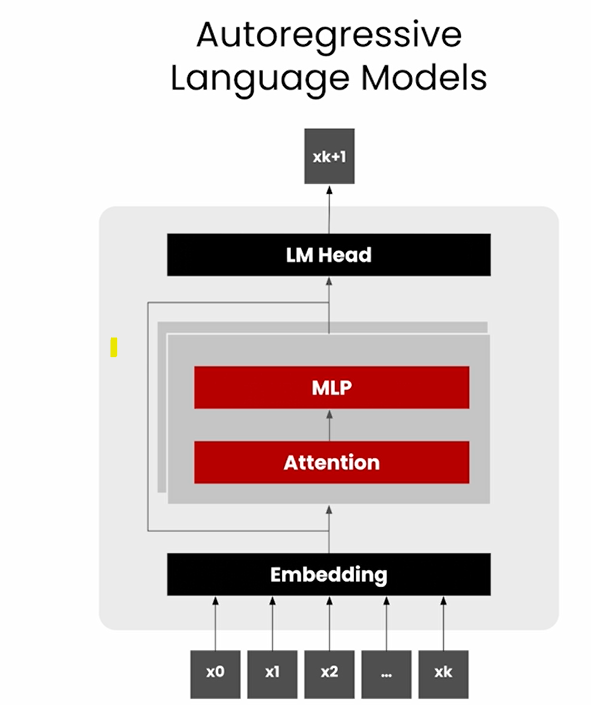

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import time
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer

Loading GPT2

In [7]:
# model_name = "gpt2"  # first time download from huggingface
model_name = "./models/gpt2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

C:\Users\archd\miniconda3\Lib\site-packages\huggingface_hub\file_download.py:149: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\archd\.cache\huggingface\hub\models--gpt2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [8]:
print(model)

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)


## Basic Inference

In [9]:
prompt = "The quick brown fox jumped over the"

# return tensorts in pytorch format. Tensorflow has diff format
inputs = tokenizer(prompt, return_tensors="pt")
inputs

{'input_ids': tensor([[  464,  2068,  7586, 21831, 11687,   625,   262]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1]])}

- Attention mask tells us which token we should attend first. Above all attention mask is 1 which means all tokens are equally imp. 


Passing inputs to the model and generating the next token
- For now no gradients are needed as we wont be training an LLM and we are just generating tokens

In [10]:
with torch.no_grad():
    outputs = model(**inputs)

logits = outputs.logits
print(logits.shape)

torch.Size([1, 7, 50257])


Above output dimensions
- 1 is the batch size
- 7 is total number of tokens in the input
- 50257 is the vocabulary size

It generates token for considering all previous token at given point. 
- 3rd output is token generated considering 0-3 tokens
- At inference we are only interested in last generated token but during training we consider all generated tokens.


In [11]:
last_logits = logits[0, -1, :]
# which index has max value i.e. highest probability
next_token_id = last_logits.argmax()
next_token_id

tensor(13990)

In [13]:
# next token for prompt: "The quick brown fox jumped over the"
tokenizer.decode(next_token_id)

' fence'

### Logits Check

In [22]:
# last logits contains probability of next word
last_logits

tensor([-92.9353, -92.3160, -96.0634,  ..., -95.3960, -96.1433, -94.6932])

In [23]:
tokenizer.decode(0)

'!'

In [24]:
import numpy as np
last_logits.argmax()

tensor(13990)

In [25]:
np.max(list(last_logits))

-81.89552

In [26]:
last_logits[13990]

tensor(-81.8955)

In [28]:
tokenizer.decode(13990)

' fence'

### Different Token Generation Startegies

#### Top k

In [29]:
top_k = torch.topk(last_logits, k=10)
tokens = [tokenizer.decode(tk) for tk in top_k.indices]
tokens

[' fence',
 ' edge',
 ' railing',
 ' wall',
 ' table',
 ' tree',
 ' top',
 ' counter',
 ' ground',
 ' side']

#### Multimonial Distributions

In [34]:
probs = torch.nn.functional.softmax(last_logits, dim=-1)

# Sample from the multinomial distribution based on the computed probabilities.
# torch.multinomial needs probabilities and the number of samples to draw.
# Here we draw one sample which will be our token index.
for _ in range(10):
    token_index = torch.multinomial(probs, num_samples=1)
    print(token_index, ':', tokenizer.decode(token_index.item()))

tensor([8469]) :  crack
tensor([3290]) :  dog
tensor([13990]) :  fence
tensor([39479]) :  roadside
tensor([13990]) :  fence
tensor([3797]) :  cat
tensor([8222]) :  forest
tensor([29494]) :  skinny
tensor([3223]) :  dark
tensor([9036]) :  barrel


### Prefill and Decode

Append token and generate next token considering all previous tokens

In [36]:
next_inputs = {
    "input_ids": torch.cat(
        [inputs["input_ids"], next_token_id.reshape((1, 1))],
        dim=1
    ),
    "attention_mask": torch.cat(
        [inputs["attention_mask"], torch.tensor([[1]])],
        dim=1
    ),
}

In [37]:
print(next_inputs["input_ids"],
      next_inputs["input_ids"].shape)
print(next_inputs["attention_mask"],
      next_inputs["attention_mask"].shape)

tensor([[  464,  2068,  7586, 21831, 11687,   625,   262, 13990]]) torch.Size([1, 8])
tensor([[1, 1, 1, 1, 1, 1, 1, 1]]) torch.Size([1, 8])


In [38]:
with torch.no_grad():
    outputs = model(**next_inputs)

logits = outputs.logits
last_logits = logits[0, -1, :]
next_token_id = last_logits.argmax()

# # next token for prompt: "The quick brown fox jumped over the fence"
tokenizer.decode(next_token_id)

' and'

#### Functions

In [39]:
def generate_token(inputs):
    with torch.no_grad():
        outputs = model(**inputs)

    logits = outputs.logits
    last_logits = logits[0, -1, :]
    next_token_id = last_logits.argmax()
    return next_token_id

In [46]:
generated_tokens = []
prompt = "The quick brown fox jumped over the"
next_inputs = tokenizer(prompt, return_tensors="pt")
durations_s = []
for _ in range(10):
    t0 = time.time()
    next_token_id = generate_token(next_inputs)
    durations_s += [time.time() - t0]
    
    next_inputs = {
        "input_ids": torch.cat(
            [next_inputs["input_ids"], next_token_id.reshape((1, 1))],
            dim=1),
        "attention_mask": torch.cat(
            [next_inputs["attention_mask"], torch.tensor([[1]])],
            dim=1),
    }
    
    next_token = tokenizer.decode(next_token_id)
    generated_tokens.append(next_token)

print(f"{sum(durations_s)} s")
print(generated_tokens)

0.6471211910247803 s
[' fence', ' and', ' ran', ' to', ' the', ' other', ' side', ' of', ' the', ' fence']


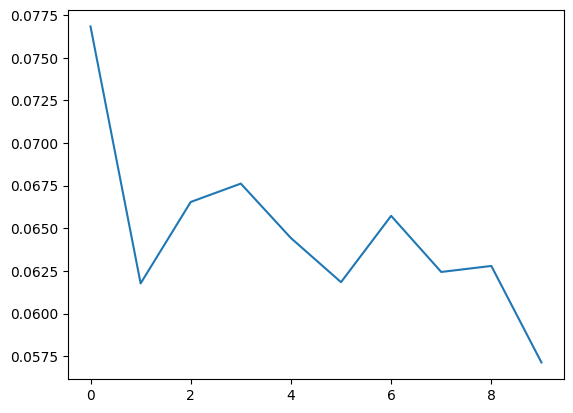

In [47]:
plt.plot(durations_s)
plt.show()

- Plot token generation time
- The x-axis here is the token number
- The y-axis is the time to generate a token in millisenconds (ms)

## KV Caching

KV-caching is a technique to speed up token generation by storing some of the tensors in the attention head for use in subsequent generation steps.

Previous KV values can be cached and concatenated to speed up computation. Allows skipping redundant computation of past tokens

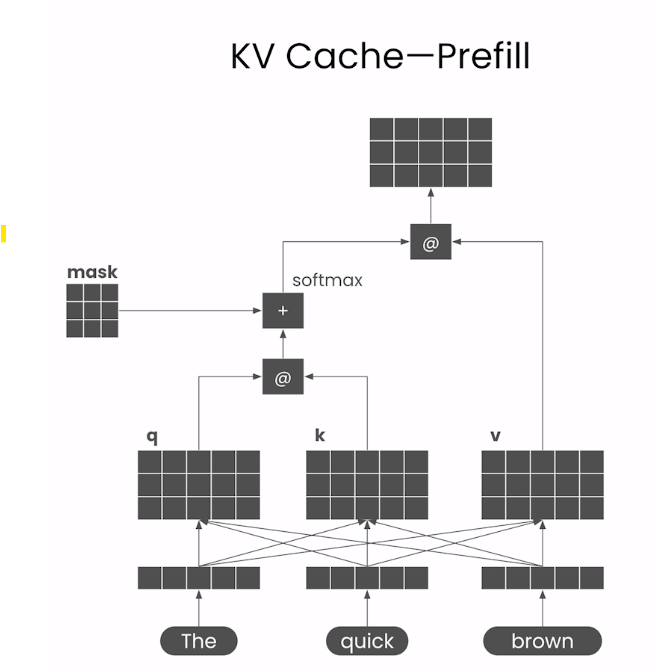

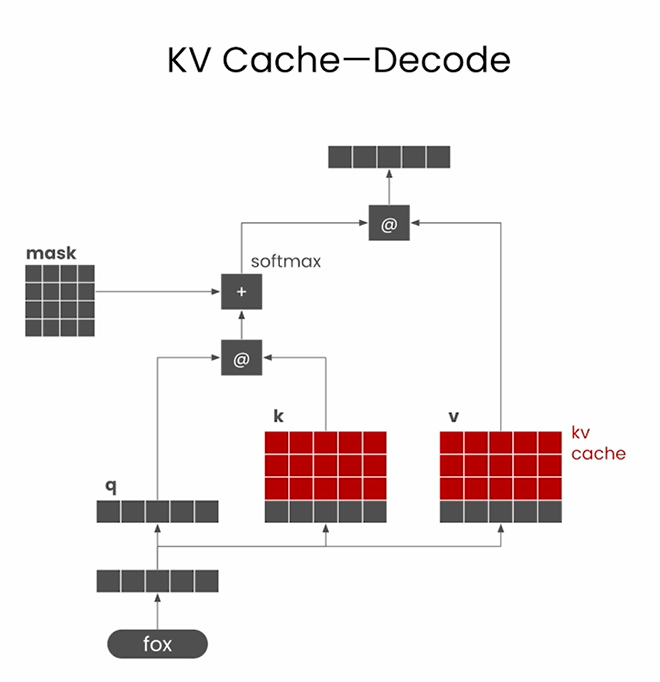

In [48]:
# return key values along with next token id

def generate_token_with_past(inputs):
    with torch.no_grad():
        outputs = model(**inputs)

    logits = outputs.logits
    last_logits = logits[0, -1, :]
    next_token_id = last_logits.argmax()
    return next_token_id, outputs.past_key_values

In [49]:
generated_tokens = []
prompt = "The quick brown fox jumped over the"
next_inputs = tokenizer(prompt, return_tensors="pt")
durations_cached_s = []
for _ in range(10):
    t0 = time.time()
    next_token_id, past_key_values = \
        generate_token_with_past(next_inputs)
    durations_cached_s += [time.time() - t0]
    
    next_inputs = {
        "input_ids": next_token_id.reshape((1, 1)),
        "attention_mask": torch.cat(
            [next_inputs["attention_mask"], torch.tensor([[1]])],
            dim=1),
        "past_key_values": past_key_values,
    }
    
    next_token = tokenizer.decode(next_token_id)
    generated_tokens.append(next_token)

print(f"{sum(durations_cached_s)} s")
print(generated_tokens)

0.38398098945617676 s
[' fence', ' and', ' ran', ' to', ' the', ' other', ' side', ' of', ' the', ' fence']


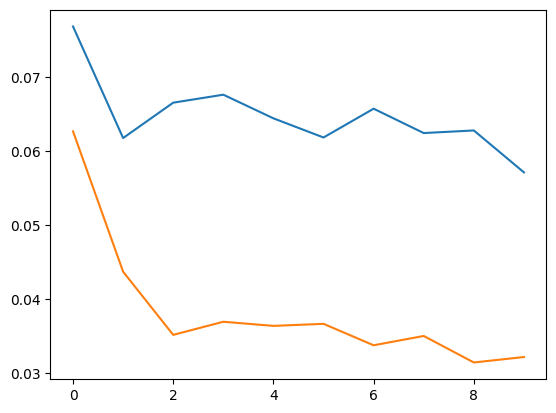

In [50]:
plt.plot(durations_s)
plt.plot(durations_cached_s)
plt.show()